# Digit Recognition using ResNet18

This notebook implements a deep learning solution for digit recognition using a ResNet18 architecture. The project uses the MNIST dataset to train a convolutional neural network that can classify handwritten digits from 0-9.

## Project Overview
- **Dataset**: MNIST handwritten digits (28x28 grayscale images)
- **Architecture**: ResNet18 adapted for single-channel input
- **Framework**: PyTorch with Apple Silicon GPU acceleration (MPS)
- **Goal**: Achieve high accuracy in digit classification


## 1. Data Loading and Preprocessing

This cell loads the MNIST training data from CSV format and prepares it for training:
- Loads training data from CSV file
- Extracts labels and image pixel data
- Converts to PyTorch tensors with proper data types
- Reshapes images to (N, 1, 28, 28) format for CNN input
- Applies data augmentation (random rotation) for training
- Normalizes images using dataset statistics
- Splits data into training (90%) and validation (10%) sets
- Creates DataLoaders with appropriate batch sizes and workers


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


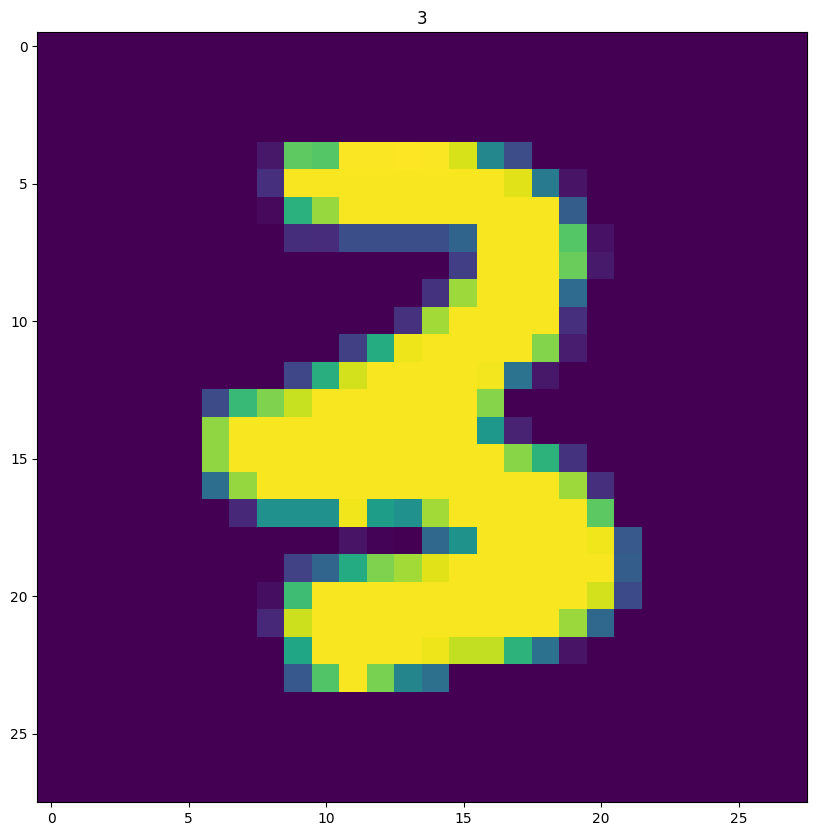

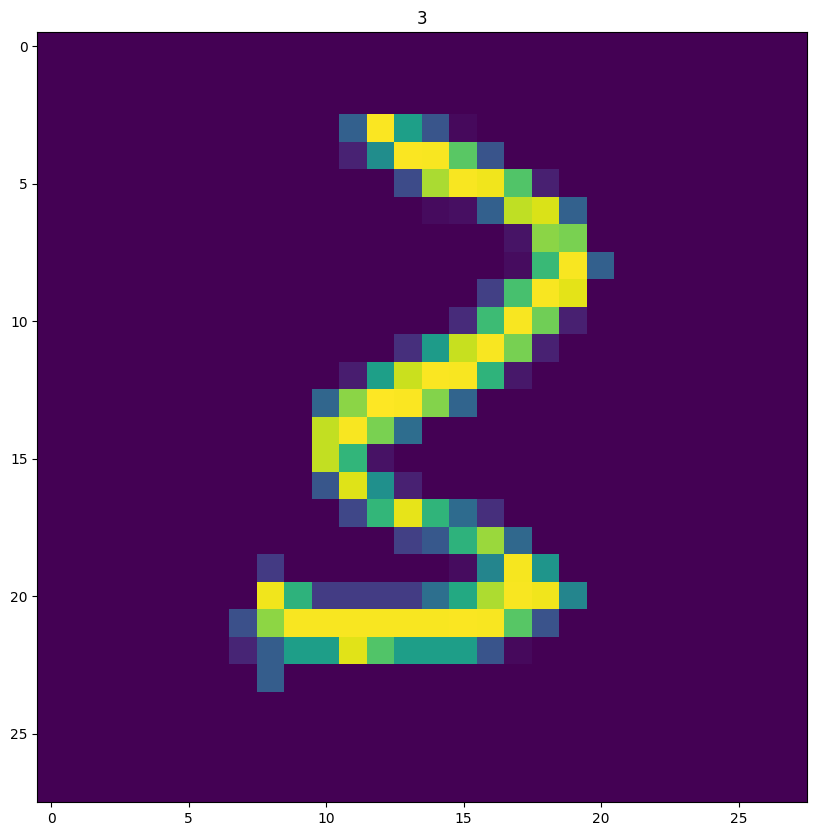

In [ ]:
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cus_data import CustomDataset

# Load the training data
train_data = pd.read_csv('./Downloads/digit-recognizer/train.csv')

# Extract labels and images
labels = train_data.iloc[:, 0].values  # First column is the label
images = train_data.iloc[:, 1:].values  # Remaining columns are the image pixels

# Convert labels and images to tensors
labels_tensor = torch.tensor(labels, dtype=torch.long)
images_tensor = torch.tensor(images, dtype=torch.float)

# Reshape images to (N, 1, 28, 28)
images_tensor = images_tensor.view(-1, 1, 28, 28)

# Combine images and labels into a single dataset
dataset = [(images_tensor[i], labels_tensor[i]) for i in range(len(labels_tensor))]

# Define transforms for training and validation
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.Normalize((0.1310,), (0.3085,))
])
transforms_valid = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((0.1310,), (0.3085,))
])

# Split the dataset into training and validation (10% validation)
valid_size = int(0.1 * len(train_data))
train_size = len(train_data) - valid_size
train_subset, valid_subset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Wrap subsets with CustomDataset and transforms
train_data = CustomDataset(train_subset, transforms_train)
valid_data = CustomDataset(valid_subset, transforms_valid)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

# Visualize a sample image and label
plt.figure(figsize=(10, 10))
plt.title(f'{train_data[15][1]}')
plt.imshow(train_data[15][0][0])
plt.show() 

## 2. GPU Setup and Device Configuration

Checks for Apple Silicon GPU (MPS) availability and configures the device for optimal performance. MPS (Metal Performance Shaders) provides GPU acceleration on Apple Silicon Macs.


In [ ]:
import torch
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.") 

tensor([1.], device='mps:0')


## 3. Training and Evaluation Functions

Defines the core training infrastructure:
- **train()**: Implements one epoch of training with forward pass, loss calculation, backpropagation, and optimizer step
- **evaluate()**: Validates model performance on validation set without gradient computation
- **plot_stats()**: Visualizes training/validation loss and accuracy curves
- **fit()**: Main training loop with early stopping, learning rate scheduling, and best model checkpointing
- **Model Architecture**: ResNet18 adapted for MNIST (single channel input, 10 output classes)
- **Training Setup**: Adam optimizer, StepLR scheduler, CrossEntropyLoss


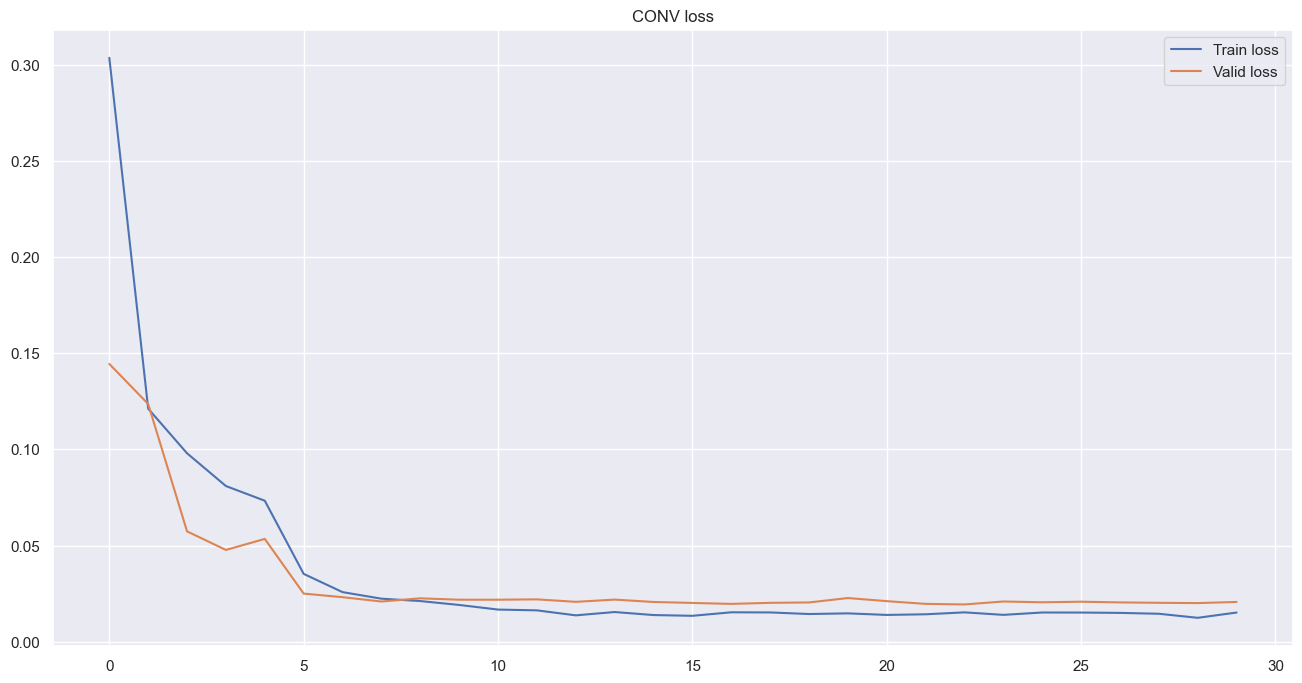

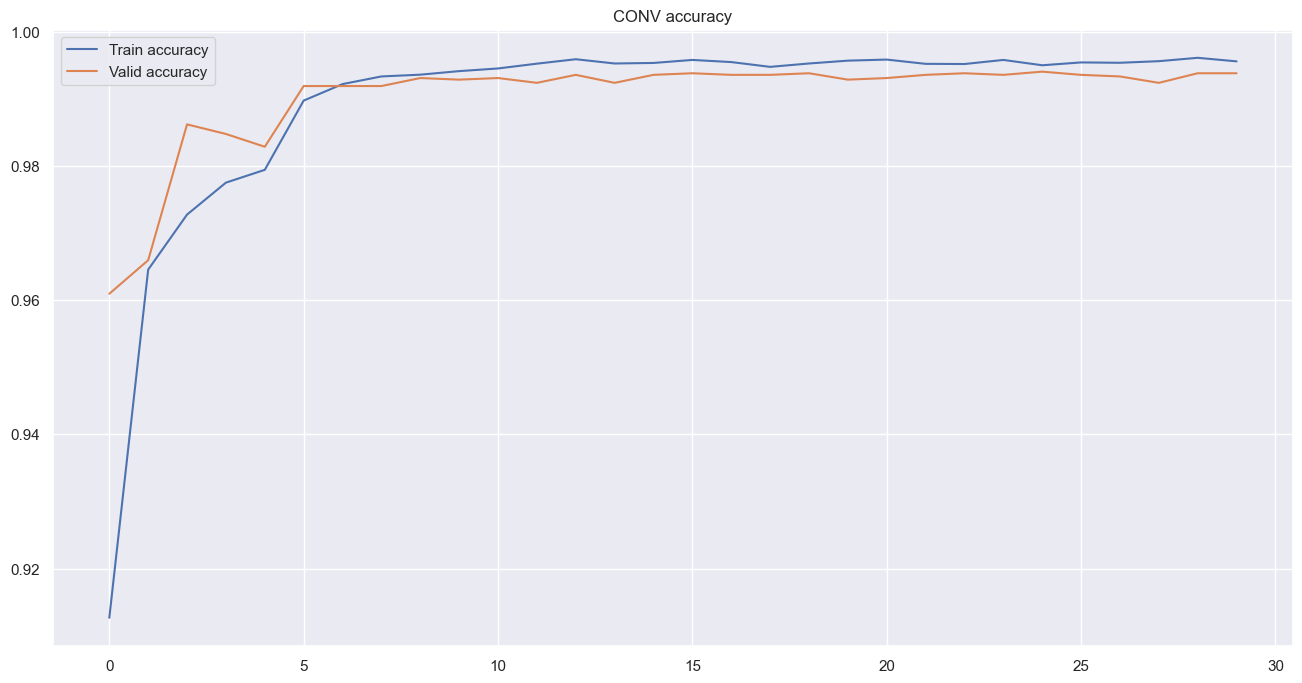

In [ ]:
from torch.optim import Optimizer
import seaborn as sns
from tqdm import tqdm


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, scheduler):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(mps_device), y.to(mps_device)
        
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()
    # Update learning rate
    scheduler.step() 
    
    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(mps_device), y.to(mps_device)
        
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title, scheduler, best_loss, best_model_weights, patience):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, scheduler)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
                # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                # Load the best model weights
                model.load_state_dict(best_model_weights) 
                break
    model.load_state_dict(best_model_weights)

# # (28, 28) -> (784)
from torchvision.models import resnet18
import torch.nn as nn

# Build ResNet18 for MNIST (single channel, 10 classes)
MNIST_model = resnet18(pretrained=False)
MNIST_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change input channels to 1
MNIST_model.fc = nn.Linear(MNIST_model.fc.in_features, 10)  # Output 10 classes

MNIST_model.to(mps_device)  # Move model to MPS device (Apple Silicon GPU)

# Optimizer, scheduler, and loss function
optimizer = torch.optim.Adam(MNIST_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)
loss_fn = nn.CrossEntropyLoss()

# Train the model
fit(MNIST_model, train_loader, valid_loader, optimizer, loss_fn, 30, 'CONV', scheduler)

## 4. Improved Training Function with Early Stopping

Enhanced version of the fit function with proper early stopping implementation:
- Tracks best validation loss and model weights
- Implements patience-based early stopping to prevent overfitting
- Automatically restores best model weights when training stops
- Provides cleaner notebook output with progress visualization


In [ ]:
from IPython.display import clear_output
import copy

def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title, scheduler, best_loss, best_model_weights, patience):
    # Lists to store loss and accuracy history for plotting
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, scheduler)
        # Evaluate on validation set
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        # Record metrics
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()  # Clear previous output for cleaner notebook display

        # Plot training/validation loss and accuracy
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        # Early stopping: save best model weights and reset patience if validation improves
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Save best weights
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                # Restore best model weights and stop training
                model.load_state_dict(best_model_weights)
                break

    # Ensure best weights are loaded
    model.load_state_dict(best_model_weights)

## 5. Model Training Execution

Initializes training parameters and starts the training process:
- Sets up early stopping parameters (patience=10)
- Trains the ResNet18 model for up to 15 epochs
- Monitors validation loss to prevent overfitting
- Automatically saves the best performing model weights


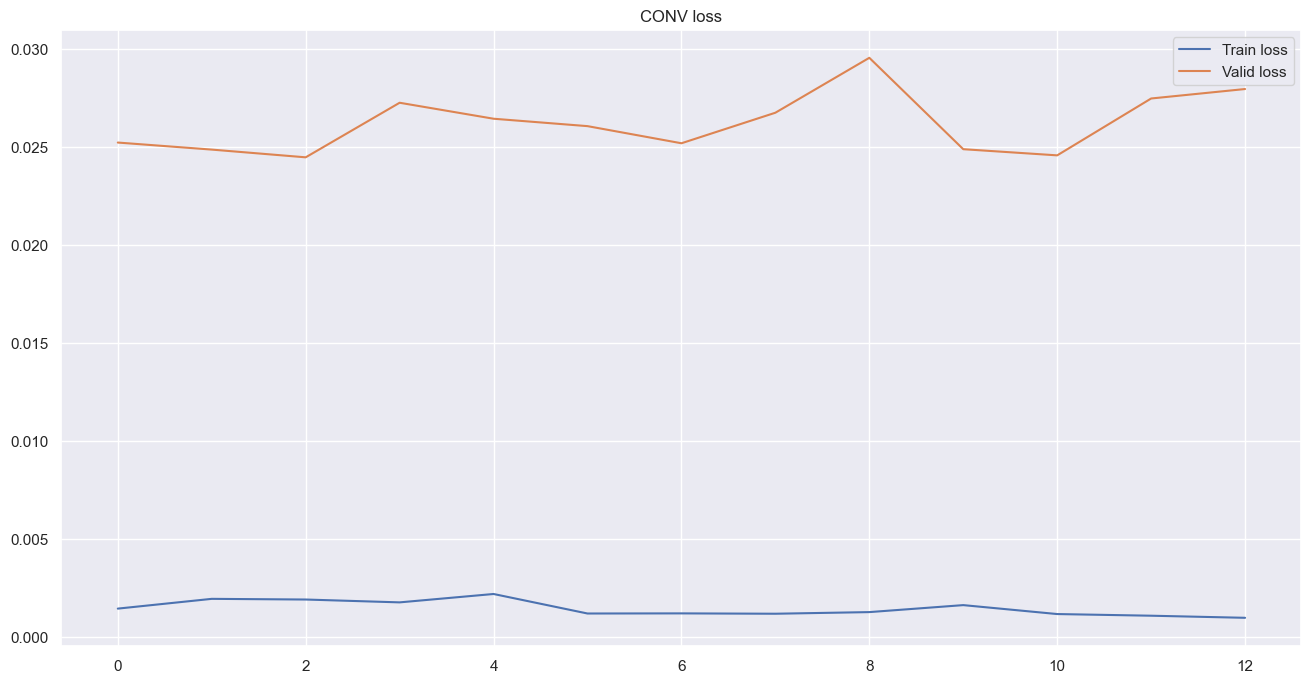

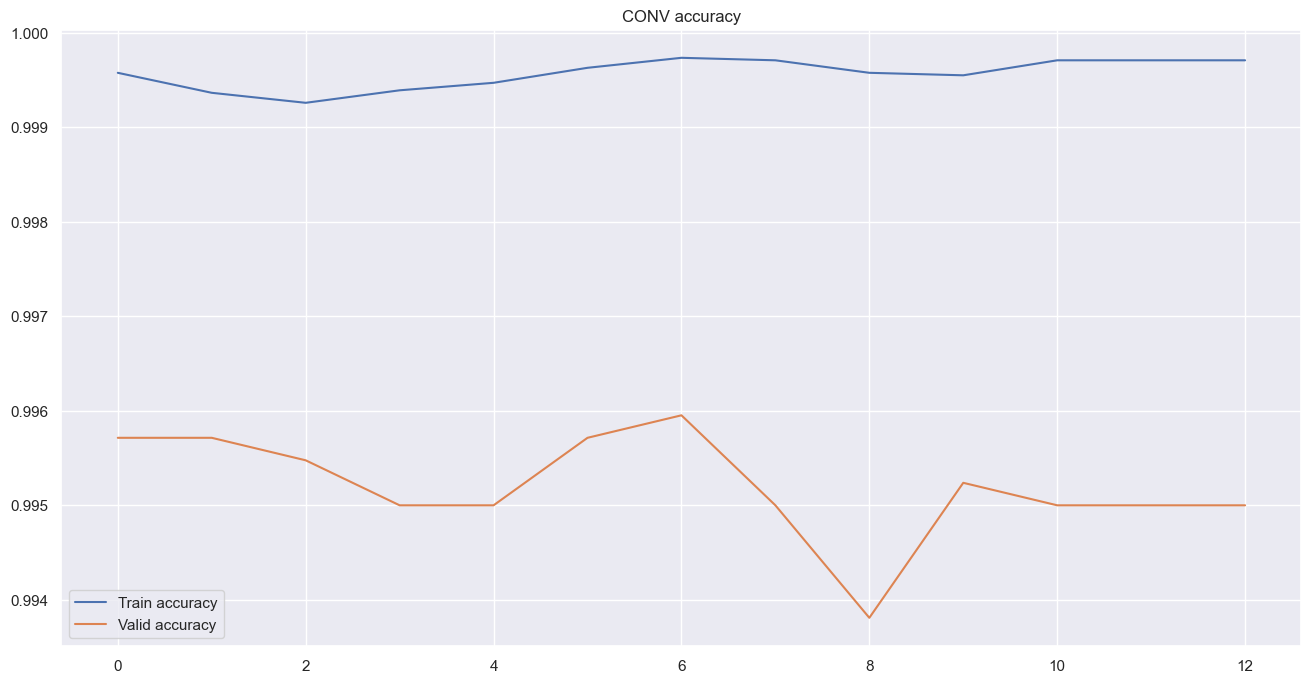

In [ ]:
best_loss = float('inf') 
best_model_weights = None 
patience = 10
fit(MNIST_model, train_loader, valid_loader, optimizer, loss_fn, 15, 'CONV', scheduler, best_loss, best_model_weights, patience) 

## 6. Test Data Preparation

Loads the test dataset for final predictions:
- Reads test data from CSV file (no labels provided)
- Contains unlabeled digit images for competition submission


In [128]:
import pandas as pd


test_data = pd.read_csv('./Downloads/digit-recognizer/test.csv') 

## 7. Test Data Tensor Conversion

Converts test data to PyTorch tensor format for model inference.


In [129]:
test_tensor = torch.tensor(test_data.values, dtype=torch.float)  

## 8. Test Data Reshaping

Reshapes test images to the correct format for the CNN:
- Reshapes from flat vectors to 28x28 images
- Adds channel dimension (unsqueeze) to match model input requirements


In [130]:
test_tensor = test_tensor.view(-1, 28, 28)
test_tensor = test_tensor.unsqueeze(1)

## 9. Verify Test Data Shape

Confirms that the test data has been properly reshaped to the expected dimensions (1, 28, 28).


In [131]:
test_tensor[0].shape

torch.Size([1, 28, 28])

## 10. Apply Validation Transforms

Applies the same normalization transforms used during validation to the test data for consistent preprocessing.


In [132]:
test_tensor = CustomDataset(test_tensor, transforms_valid)     

## 11. Create Test DataLoader

Creates a DataLoader for efficient batch processing of test data during inference.


In [133]:
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

## 12. Generate Predictions on Test Set

Runs inference on the entire test dataset:
- Sets model to evaluation mode
- Processes test data in batches for efficiency
- Generates predictions for all test images
- Uses GPU acceleration for faster inference


In [134]:
MNIST_model.eval()

all_results = []

for x in tqdm(test_loader):
    x = x.to(mps_device)
    output = MNIST_model(x) 
    
    all_results.append(output.argmax(dim=1)) 
print("ALL DONE!") 

100%|█████████████████████████████████████████| 438/438 [00:07<00:00, 56.02it/s]

ALL DONE!


## 13. Concatenate Prediction Results

Combines all batch predictions into a single tensor and moves to CPU for further processing.


In [135]:
concatenated_tensor = torch.cat(all_results) 
concatenated_tensor = concatenated_tensor.cpu() 

## 14. Create Submission DataFrame

Formats predictions into the required submission format:
- Creates ImageId column (1-indexed)
- Maps predictions to Label column
- Prepares data for competition submission


In [136]:
testPredictionDataFrame=pd.DataFrame({
    'ImageId': range(1, len(concatenated_tensor) + 1),
    'Label': concatenated_tensor
})

## 15. Save Submission File

Exports the predictions to a CSV file for competition submission.


In [137]:
testPredictionDataFrame.to_csv('./Downloads/digit-recognizer/solution.csv', index=False)

## 16. Save Trained Model

Saves the trained ResNet18 model weights for future use and deployment.


In [124]:
torch.save(MNIST_model.state_dict(), f'DigitRecognitionResNet18.pt') 